# Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn.datasets import make_blobs

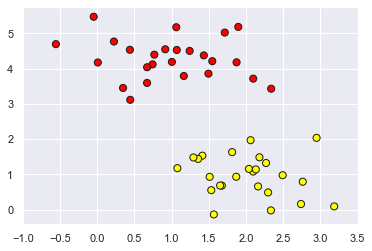

In [4]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn',edgecolor = 'k');
plt.xlim(-1, 3.5);

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. But there is more than one possible linear seperators that perfectly discriminate between the two classes.

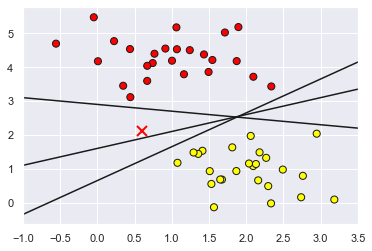

In [22]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which one you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label.

Evidently the simple intuition of "drawing a line between classes" is not enough.

## Support Vector Machines: Maximizing the Margin

Rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point:

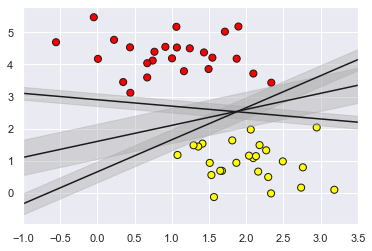

In [23]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

**In support vector machines, the line/hyperplane that maximizes this margin is the optimal model.**

* This requires to solve the optimization problem (**primal**) with $n+d+1$ variables:

\begin{align*}
\min_{\mathbf{w}\in\mathbb{R}^d,w_0\in\mathbb{R}, \xi\in\mathbb{R}^n} & \quad \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
\mbox{subject to} & \quad y_i  (\mathbf{x}_i^\top \mathbf{w}  + w_0)\geq 1 -\xi_i, \\
                             & \quad  \xi_i \geq 0,  \quad  i=1,\dots,n
\end{align*}

*  $\mathbf{x}^\top \mathbf{w}^*  + w_0^* = 0$ is the equation of separating plane. 

* $C>0$ is a hyperparameter controlling the tolerance of the misclassfication rate on traning data. $C = \infty$ means no tolerance.

* In practice, we solve its **dual** problem  with just $n$ variables:

\begin{align*}
\max_{\boldsymbol\alpha \in \mathbb{R}^n} & \quad  \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n \sum_{j=1}^n y_i y_j \alpha_i\alpha_j \langle \mathbf{x}_i, \mathbf{x}_j \rangle \\
\mbox{subject to}  & \quad \sum_{i=1}^n \alpha_i y_i = 0, \\
                   & \quad  0 \leq \alpha_i \leq C, \quad  i=1,\dots,n
\end{align*}


* Making the prediction for $\mathbf{x}$ mainly requires computations of $\alpha_i y_i \langle \mathbf{x}, \mathbf{x}_i \rangle$ for a few $i$'s, yet not all.

We use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the $C$ parameter to a very large number.

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Create a function that plots SVM linear decision boundaries:

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca() #get the current Axes instance on the current figure
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot linear decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
               model.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none',
               edgecolors='k')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

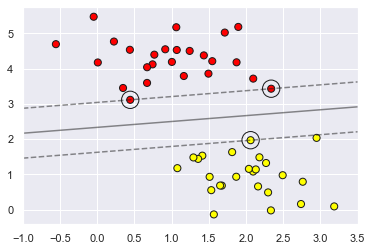

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
plt.xlim(-1, 3.5)
plot_svc_decision_function(model)

This is the linear separator that maximizes the margin between the two sets of points. The training points that touch the margin are indicated by the black circles. These points are the pivotal elements of this fit, and are known as the **support vectors**.

In [10]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

**Only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit**, because these points do not contribute to the loss function used to fit the model. Their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

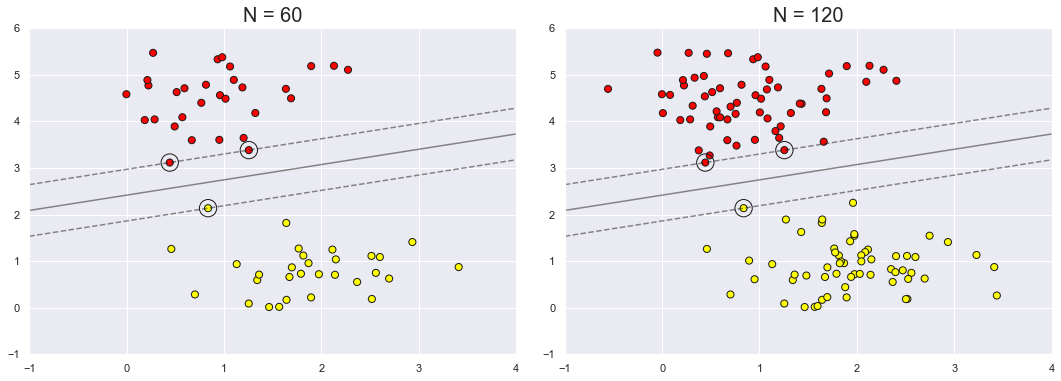

In [28]:
def plot_svm(N, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    
    model = SVC(kernel='linear', C=1e10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1) # adjust the subplot layout parameters

for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N),fontsize=20)

The model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

## Tuning the SVM: Soft Margin

Soft margin SVMs deal with dataset for which a perfect decision boundary doesn't exist. **They allow misclassified training points.** The hardness of the margin is controlled by a tuning parameter ``'C'`` in ``SVC``. 

* For very large ``'C'``, the margin is hard, and points cannot lie in it, rendering small margin. 
* For smaller ``'C'``, the margin is softer, and can grow to encompass some points with larger margin.

The plot below shows how a changing ``'C'`` parameter affects the learned SVM via the soft margin:

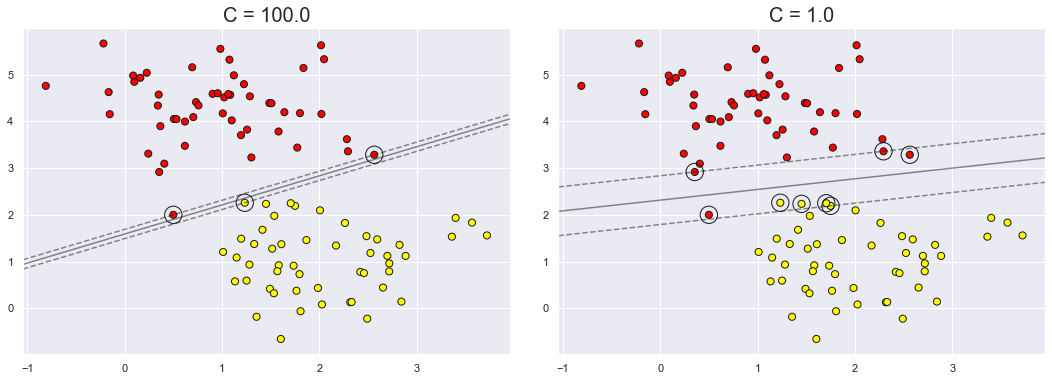

In [29]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.7)

X = np.concatenate((X,np.array([0.5,2]).reshape(1,2)) )
y = np.append(y, 0)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100, 1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), fontsize=20)

The optimal value of the ``'C'`` parameter will depend on the dataset, and should be tuned using **cross-validation**.

##  Beyond linear boundaries: Kernel SVM

SVM becomes extremely powerful when it is combined with kernels. To motivate the need for kernels, let's look at some data that is not linearly separable:

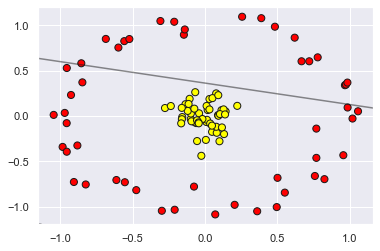

In [14]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will be able to separate this data. But we can project the data into a higher dimension such that a linear separator would be sufficient. For example, add a 3rd coordinate by
$$
z = e^{-x^2-y^2}
$$

In [15]:
z = np.exp(-(X ** 2).sum(axis = 1)) 

We visualize this extra data dimension using a three-dimensional plot. With the additional dimension, the data becomes trivially linearly separable by a separating plane.

Text(0.5, 0, 'z')

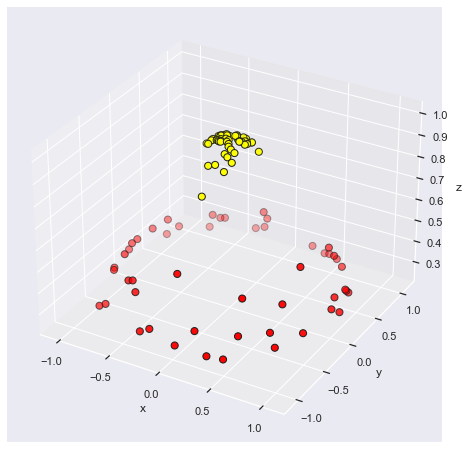

In [16]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap='autumn', edgecolor = 'k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

* Transform the data onto a higher dimensional feature space via a mapping function $\phi$,  and a linear SVM can get the job done in the transformed feature space.
* **Kernel trick**: the **dual formulation** allows us to **implicitly** define the feature transform $\phi$ by introducing the **kernel**:

$$
K(x_i,x_j) := \langle \phi(x_i), \phi(x_j) \rangle 
$$

* linear (trivial) kernel with identity $\phi$: 

$$
K(x_i,x_j) = \langle x_i, x_j \rangle
$$

* polynomial kernel: 

$$
K(x_i,x_j) = \langle x_i, x_j \rangle^p
$$

* radial basis function (RBF) kernel:
$$
K(x_i,x_j) = e^{-\frac{\|x_i-x_j\|^2}{2\gamma^2}}
$$

The degree $p$ and $\gamma$ are hyperparamters of model.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to a radial basis function (RBF) kernel, using the kernel model hyperparameter:

In [17]:
clf = SVC(kernel='rbf', C=1E6, gamma = 'auto')
clf.fit(X, y)

SVC(C=1000000.0, gamma='auto')

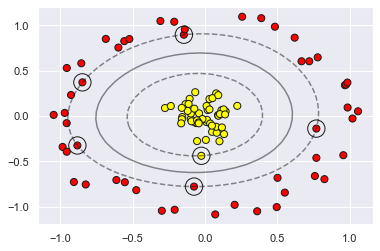

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolor = 'k')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
             s=300, lw=1, facecolors='none');

## Cancer Dataset

Use the built-in breast cancer dataset from Scikit Learn. 

In [19]:
from sklearn.datasets import load_breast_cancer

In [20]:
cancer = load_breast_cancer()

The data set is presented in a dictionary form:

In [21]:
print(cancer.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [22]:
cancer['data'].shape

(569, 30)

In [23]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [24]:
cancer['filename']

'breast_cancer.csv'

In [25]:
print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [26]:
cancer['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

## Set up DataFrame

In [27]:
df_feat = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [28]:
cancer['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [29]:
df_target = pd.DataFrame(cancer['target'],columns=['Cancer'])
df_target.head()

,Cancer
0,0
1,0
2,0
3,0
4,0


Check out the feature dataframe

In [30]:
df_feat.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Data Analysis



## Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

Convert data into numpy arrays

In [32]:
df_feat = np.array(df_feat)
df_target = np.array(df_target).flatten() # 1D array
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=0.30, random_state=101)

## Train the SVM Classifier

In [33]:
from sklearn.svm import SVC

In [34]:
svm = SVC(gamma = 'auto')
svm.fit(X_train,y_train)

# default gamma = 1/n_features
# default kernel = Gaussian RBF: 'rbf'

SVC(gamma='auto')

## Predictions and Evaluations

In [35]:
predictions = svm.predict(X_test)

In [36]:
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
print(confusion_matrix(y_test,predictions))

[[  0  66]
 [  0 105]]


In [38]:
print(predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [39]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.61      1.00      0.76       105

    accuracy                           0.61       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.38      0.61      0.47       171



/Users/py253733/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/py253733/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/py253733/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notice that everything is classified into the second class. This means our model needs to have it parameters adjusted.
We can search for parameters using a GridSearch.

# Gridsearch

We  use a grid search cross-validation to explore combinations of parameters. Here we will adjust ``'C'`` (which controls the margin hardness) and ``'gamma'`` (which controls the size of the radial basis function kernel), and determine the best model.
 This method is common enough that Scikit-learn has this functionality built in with ``GridSearchCV``. ``GridSearchCV`` takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested. 

In [40]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 

In [41]:
from sklearn.model_selection import GridSearchCV

``GridSearchCV`` takes an estimator like ``SVC``, and creates a new estimator, that behaves exactly the same. You should add ``refit=True`` and choose ``verbose`` to whatever number you want, higher the number, the more verbose (verbose means the text output describing the process).

In [42]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3,cv=3) # verbose controls the level of messages

What fit does is a bit more involved then usual. First, it runs the same loop with cross-validation, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

In [43]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END ....................C=0.1, gamma=1;, score=0.632 total time=   0.0s
[CV 2/3] END ....................C=0.1, gamma=1;, score=0.632 total time=   0.0s
[CV 3/3] END ....................C=0.1, gamma=1;, score=0.636 total time=   0.0s
[CV 1/3] END ..................C=0.1, gamma=0.1;, score=0.632 total time=   0.0s
[CV 2/3] END ..................C=0.1, gamma=0.1;, score=0.632 total time=   0.0s
[CV 3/3] END ..................C=0.1, gamma=0.1;, score=0.636 total time=   0.0s
[CV 1/3] END .................C=0.1, gamma=0.01;, score=0.632 total time=   0.0s
[CV 2/3] END .................C=0.1, gamma=0.01;, score=0.632 total time=   0.0s
[CV 3/3] END .................C=0.1, gamma=0.01;, score=0.636 total time=   0.0s
[CV 1/3] END ................C=0.1, gamma=0.001;, score=0.632 total time=   0.0s
[CV 2/3] END ................C=0.1, gamma=0.001;, score=0.632 total time=   0.0s
[CV 3/3] END ................C=0.1, gamma=0.001;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

Inspect the best parameters found by ``GridSearchCV`` in the ``best_params_`` attribute, and the best estimator in the ``best_estimator_`` attribute:

In [44]:
grid.best_params_

{'C': 10, 'gamma': 0.0001}

In [45]:
grid.best_estimator_

SVC(C=10, gamma=0.0001)

Re-run predictions on this ``grid`` object.

In [46]:
grid_predictions = grid.predict(X_test)

In [47]:
print(confusion_matrix(y_test,grid_predictions))

[[ 60   6]
 [  3 102]]


In [48]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        66
           1       0.94      0.97      0.96       105

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



## Summary

SVM is a powerful classification method for a number of reasons:

* Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
* Once the model is trained, the prediction phase is very fast.
* The optimization problem size (number of variables) only depends on the number of samples $n$, not on the dimension of data. So they work well with very high-dimensional data
* Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have disadvantages as well:

* The scaling with the number of samples $n$ is $\mathcal{O}(n^3)$ at worst, or $\mathcal{O}(n^2)$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
* The results are strongly dependent on a suitable choice for the softening parameter ``'C'``. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.